# Evaluating iXnos Models

In [1]:
import sys
import os
sys.path.append("src")
from model import load_ixnos, iXnos
from src import *
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from Bio import SeqIO
import seaborn as sns

# Codon information
alpha="ACGT"
nts = ["A", "C", "G", "T"]
codons = [x+y+z for x in alpha for y in alpha for z in alpha]
cod2id = {codon:idx for idx, codon in enumerate(codons)}
id2cod = {idx:codon for codon, idx in cod2id.items()}
nt2id = {nt:idx for idx, nt in enumerate(alpha)}
id2nt = {idx:nt for nt, idx in nt2id.items()}
# Indices of nucleotides and codons used in models
nt_indices = np.arange(-15, 15)
codon_indices = np.arange(-5, 5)

In [2]:
def encode(val, arr:list):
    # Given an array of potential values (arr) and a value (val), 
    # return a 1-hot-encoded numpy array of that value
    # e.g. encode(A ,[A, T, G, C]) -> [1, 0, 0, 0]
    output = np.zeros(len(arr))
    output[arr.index(val)] = 1
    return output

def predict(i, model, df):
    # Given index i in a y dataframe (df), apply model to predict
    # scaled count for the codon at that index. 
    y = df.iloc[i]
    gene = y["gene"]
    # get codon indices
    n5p4 = codon_indices + y["cod_idx"]
    codon_vector = []
    for cod in n5p4: 
        df_codon_idx = df.loc[
            (df['gene'] == gene) & 
            (df['cod_idx'] == cod), "cod_seq"].item()
        codon_vector.append(
            encode(
                df_codon_idx,
                codons))
    codon_vector = np.concatenate(codon_vector)

    footprint_nt = "".join(df.loc[(df['gene'] == gene) & (df['cod_idx'].isin(n5p4)), "cod_seq"].tolist())

    nt_vector = []
    for i in footprint_nt:
        nt_vector.append(encode(i, nts))
    nt_vector = np.concatenate(nt_vector)
    input = np.concatenate([codon_vector, nt_vector])
    # input = np.concatenate([nt_vector, codon_vector])
    input = torch.from_numpy(input).to(torch.float32)
    return model(input).item(), y["scaled_cts"].item()

def pred_gene(gene, ydf, model):
    # Predict scaled counts for all codons in a gene
    # NOTE: currently excludes first and last 5 codons bc truncated 
    ydf_gene = ydf[ydf["gene"] == gene]
    gene_len = len(ydf_gene) # How many codons
    pred, actual = [], []

    for i in range(gene_len):
        codon_index = ydf_gene.iloc[i]["cod_idx"]
        if i > 5 and i < gene_len - 5:
            p, t = predict(i, model, ydf_gene)
            pred.append(p)
            actual.append(t)
    return pred, actual

def plot_pred(pred, actual):
    plt.scatter(actual, pred, s=5, c='k')
    slope, intercept = np.polyfit(actual, pred, 1)
    # Generate values for the line of best fit
    fit_line = slope * np.array(actual) + intercept

    # Plot the line of best fit
    plt.plot(
        sorted(actual), sorted(fit_line), 
        color='r', linestyle="--", alpha=0.5,
        label=f'R² = {r2_score(actual, pred):.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs. Actual')
    plt.legend()
    plt.show()

def plot_counts(pred, actual, ax=None, lw=1):
    # Plot predicted and actual scaled counts along 
    # a gene.
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 2))
    ax.plot(
        range(len(actual)), actual, label="Actual",
        linewidth=lw,
    )
    ax.plot(
        range(len(pred)), pred, label="Prediction",
        linewidth=lw,
    )
    ax.set_ylabel("Scaled Counts")
    ax.set_xlabel("Codon")
    ax.legend(title=f'R² = {r2_score(actual, pred):.2f}', **legend_kwargs())
    return ax

In [3]:
# fasta_f = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"

# records = list(SeqIO.parse(fasta_f, "fasta"))
# gdf = pd.DataFrame({
#         'ID': [record.id for record in records],
#         'seq': [str(record.seq) for record in records]
#     }).set_index("ID")

In [4]:
# genes_from_codons = pd.DataFrame(ydf_iw_r.groupby("gene")["cod_seq"].agg(''.join))
# gdf.loc[genes_from_codons.index, "cod_gene"] = genes_from_codons["cod_seq"].values
# gdf = gdf.dropna()
# assert all(gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1))
# # gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1)
# gdf["start"] = gdf.apply(lambda row: row['seq'].find(row['cod_gene']), axis=1)
# gdf.apply(lambda row: (row["seq"][row["start"]:row["start"]+3], row["seq"][row["start"]-15:row["start"]+15]), axis=1)
# gdf.apply(lambda row: (
#     row["seq"][row["start"]:row["start"]+3], 
#     row["seq"][row["start"] + nt_indices[0]:
#                row["start"] + nt_indices[-1] + 1]
#                ), axis=1)

In [3]:
def predict2(i, model, df, gdf):
    y = df.iloc[i]
    gdf_gene = gdf.loc[y["gene"]]
    gdf_seq = gdf_gene["seq"]
    # Get index of E site in fasta sequence
    esite_index = (y["cod_idx"] - 20) * 3 + gdf_gene["start"] 
    # Find the nucleotides in the window
    footprint_nt = gdf_seq[
        esite_index + nt_indices[0]:
        esite_index + nt_indices[-1] + 1]
    # Convert nt string into codons 
    # NOTE: assumes your nt footprint is an in frame CDS containing just the codons we wanna look at
    footprint_codons = [footprint_nt[i:i+3] for i in range(0, len(footprint_nt), 3)]
    # Assemble input tensor
    codon_vector = np.concatenate([encode(i, codons) for i in footprint_codons])
    nt_vector = np.concatenate([encode(i, nts) for i in footprint_nt])
    input_vector = np.concatenate([codon_vector, nt_vector])
    input_vector = torch.from_numpy(input_vector).to(torch.float32)
    # Use this to predict scaled counts
    pred = model(input_vector).item()
    actual = y["scaled_cts"].item()
    return pred, actual

# tx = 5906
# print("OG fxn: ", predict(tx, model_iw_r, ydf_iw_r)[0])
# print("New fxn: ", predict2(tx, model_iw_r, ydf_iw_r, gdf)[0])

In [ ]:
class Experiment():
    # Class Constants: Indexing for codons / nucleotides for encoding
    ALPHA = "ACGT"  
    NTS = ["A", "C", "G", "T"]
    # Indices for nucleotide and codon windows
    NT_INDICES = np.arange(-15, 15)  # Nucleotide indices window
    CODON_INDICES = np.arange(-5, 5)  # Codon indices window
    def __init__(self, model, ydf, gdf_path):
        self.model = model
        self.ydf = ydf
        self.gdf_path = gdf_path
        self.gdf = self.load_gdf()
        # Define CODONS, COD2ID, and other mappings here in __init__
        self.CODONS = [x + y + z for x in self.ALPHA for y in self.ALPHA for z in self.ALPHA]
        self.COD2ID = {codon: idx for idx, codon in enumerate(self.CODONS)}
        self.ID2COD = {idx: codon for codon, idx in self.COD2ID.items()}
        self.NT2ID = {nt: idx for idx, nt in enumerate(self.NTS)}
        self.ID2NT = {idx: nt for nt, idx in self.NT2ID.items()}
        # Apply the model to all codons in the y dataframe
        self.ydf["encoding"] = self.ydf.apply(self.get_inputs, axis=1)
        self.ydf["prediction"] = self.ydf["encoding"].apply(lambda x: self.model(x).item())
        # Get pearson r
        self.pearson_r = pearsonr(self.ydf["scaled_cts"], self.ydf["prediction"])
    

    def load_gdf(self):
        records = list(SeqIO.parse(self.gdf_path, "fasta"))
        gdf = pd.DataFrame({
                'ID': [record.id for record in records],
                'seq': [str(record.seq) for record in records]
            }).set_index("ID")
        genes_from_codons = pd.DataFrame(self.ydf.groupby("gene")["cod_seq"].agg(''.join))
        gdf.loc[genes_from_codons.index, "cod_gene"] = genes_from_codons["cod_seq"].values
        gdf = gdf.dropna()
        assert all(gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1))
        # gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1)
        gdf["start"] = gdf.apply(lambda row: row['seq'].find(row['cod_gene']), axis=1)
        return gdf
    
    def encode(val, ref:dict):
        # Given a dict (ref) mapping values to indices a value (val), 
        # return a 1-hot-encoded numpy array of that value
        # e.g. encode(A , {A : 0, T : 1, ...}) -> [1, 0, 0, 0]
        output = np.zeros(len(ref))
        output[ref[val]] = 1
        return output
    # def encode(val, arr:list):
    #     # Given an array of potential values (arr) and a value (val), 
    #     # return a 1-hot-encoded numpy array of that value
    #     # e.g. encode(A ,[A, T, G, C]) -> [1, 0, 0, 0]
    #     # TODO: replace this with lookup in codon, nt dictionaries
    #     output = np.zeros(len(arr))
    #     output[arr.index(val)] = 1
    #     return output
    
    def get_inputs(self, row):
        # Get input vectors for a given row of the y dataframe.
        gdf_gene = self.gdf.loc[row["gene"]]
        gdf_seq = gdf_gene["seq"]
        # Get index of E site in fasta sequence
        esite_index = (row["cod_idx"] - 20) * 3 + gdf_gene["start"] 
        # Find the nucleotides in the window
        footprint_nt = gdf_seq[
            esite_index + nt_indices[0]:
            esite_index + nt_indices[-1] + 1]
        # Convert nt string into codons 
        # NOTE: assumes your nt footprint is an in frame CDS containing just the codons we wanna look at
        footprint_codons = [footprint_nt[i:i+3] for i in range(0, len(footprint_nt), 3)]
        # Assemble input tensor
        codon_vector = np.concatenate([encode(i, self.COD2ID) for i in footprint_codons])
        nt_vector = np.concatenate([encode(i, self.NT2ID) for i in footprint_nt])
        input_vector = np.concatenate([codon_vector, nt_vector])
        input_vector = torch.from_numpy(input_vector).to(torch.float32)
        return input_vector


In [7]:
# [predict2(i, model_iw_r, ydf_iw_r, gdf) for i in range(len(ydf_iw_r))]
# is this really that miuch slower than the row fxn?????

In [8]:
# def get_inputs(row):
#     gdf_gene = gdf.loc[row["gene"]]
#     gdf_seq = gdf_gene["seq"]
#     # Get index of E site in fasta sequence
#     esite_index = (row["cod_idx"] - 20) * 3 + gdf_gene["start"] 
#     # Find the nucleotides in the window
#     footprint_nt = gdf_seq[
#         esite_index + nt_indices[0]:
#         esite_index + nt_indices[-1] + 1]
#     # Convert nt string into codons 
#     # NOTE: assumes your nt footprint is an in frame CDS containing just the codons we wanna look at
#     footprint_codons = [footprint_nt[i:i+3] for i in range(0, len(footprint_nt), 3)]
#     # Assemble input tensor
#     codon_vector = np.concatenate([encode(i, codons) for i in footprint_codons])
#     nt_vector = np.concatenate([encode(i, nts) for i in footprint_nt])
#     input_vector = np.concatenate([codon_vector, nt_vector])
#     input_vector = torch.from_numpy(input_vector).to(torch.float32)
#     return input_vector

# ydf_iw_r["encoding"] = ydf_iw_r.apply(rowenc, axis=1)
# ydf_iw_r["prediction"] = ydf_iw_r["encoding"].apply(lambda x: model_iw_r(x).item())

In [9]:
# ydf_iw_r["prediction"] = ydf_iw_r["encoding"].apply(lambda x: model_iw_r(x).item())

## Iwasaki, original version

Using cpu device


/mnt/lareaulab/demaray/lareau-rotation/src/model.py:42: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  data[idx] = torch.from_numpy(val).T


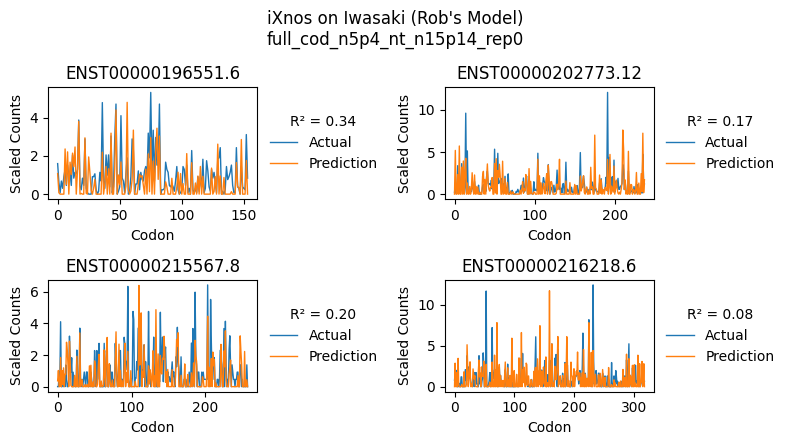

In [13]:
iwasaki_dir_r = "/mnt/lareaulab/rtunney/iXnos/expts/iwasaki"
model_dir_r = f"{iwasaki_dir_r}/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70"
model_iw_r = load_ixnos(
    f"{model_dir_r}/weights.pkl")
ydf_iw_r = pd.read_csv(
    # f"{iwasaki_dir_r}/process/te_set_bounds.size.28.28.trunc.20.20.min_cts.200.min_cod.100.top.300.data_table.txt",
    f"{iwasaki_dir_r}/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')

fig, axs, which = initialize_multiplot(4, n_cols=2, figsize=(8, 4))

for gene in ydf_iw_r["gene"].unique()[:4]:
    row, col = next(which)
    pred, actual = pred_gene(gene, ydf_iw_r, model_iw_r)
    plot_counts(pred, actual, ax=axs[row, col])
    axs[row, col].set_title(gene)
plt.tight_layout()
plt.suptitle("iXnos on Iwasaki (Rob's Model)\nfull_cod_n5p4_nt_n15p14_rep0", y=1.1)
plt.show()

In [14]:
gdf_human_path = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
rob = Experiment(model_iw_r, ydf_iw_r, gdf_human_path)

## Iwasaki, as run by me

Using cpu device


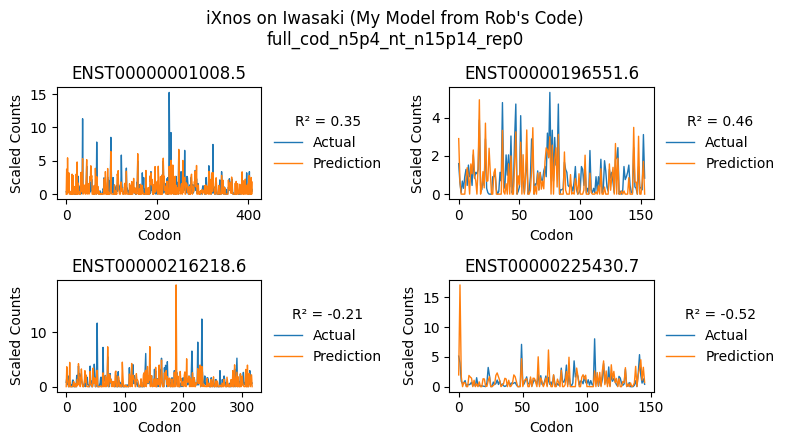

In [15]:
iwasaki_dir_j = "iXnos/expts/iwasaki"
model_dir_j = f"{iwasaki_dir_j}/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70"
model_iw_j = load_ixnos(
    f"{model_dir_j}/weights.pkl")
ydf_iw_j = pd.read_csv(
    f"{iwasaki_dir_j}/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')

fig, axs, which = initialize_multiplot(4, n_cols=2, figsize=(8, 4))

for gene in ydf_iw_j["gene"].unique()[:4]:
    row, col = next(which)
    pred, actual = pred_gene(gene, ydf_iw_j, model_iw_j)
    plot_counts(pred, actual, ax=axs[row, col])
    axs[row, col].set_title(gene)
plt.tight_layout()
plt.suptitle("iXnos on Iwasaki (My Model from Rob's Code)\nfull_cod_n5p4_nt_n15p14_rep0", y=1.1)
plt.show()

In [16]:
gdf_human_path = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
jack = Experiment(model_iw_j, ydf_iw_j, gdf_human_path)

Checking which genes don't match 

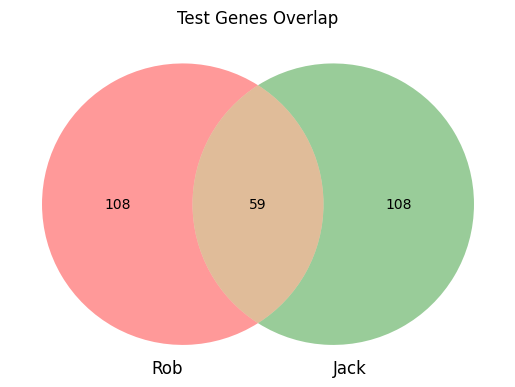

In [17]:
from matplotlib_venn import venn2

genes_r = ydf_iw_r["gene"].unique()
genes_j = ydf_iw_j["gene"].unique()
shared_genes = [i for i in genes_j if i in genes_r]
# missing_r = sorted([i for i in genes_j if i not in genes_r])
# missing_j = sorted([i for i in genes_r if i not in genes_j])

# print(len(missing_r) / len(genes_j))
# print(len(missing_j) / len(genes_r))
# print(missing_r)
# print(missing_j)

venn2([set(genes_r), set(genes_j)], set_labels=('Rob', 'Jack'))
plt.title("Test Genes Overlap")
plt.show()

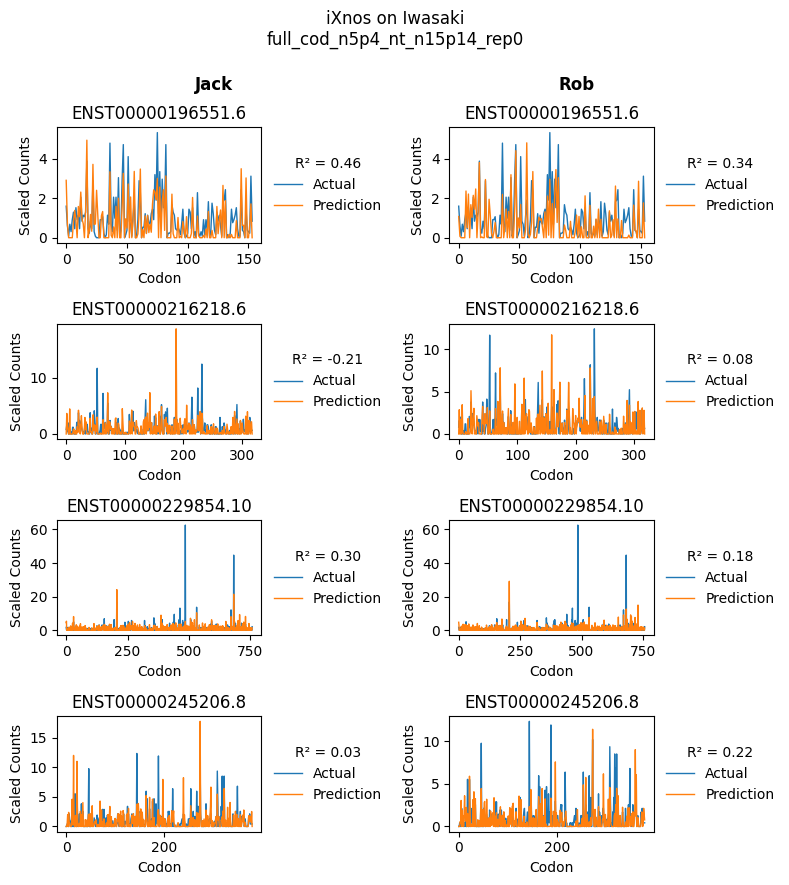

In [16]:
fig, axs, which = initialize_multiplot(8, n_cols=2, figsize=(8, 8))

for gene in shared_genes[:4]:
    # 
    row, col = next(which)
    pred_j, actual_j = pred_gene(gene, ydf_iw_j, model_iw_j)
    plot_counts(pred_j, actual_j, ax=axs[row, col])
    axs[row, col].set_title(gene)
    #
    row, col = next(which)
    pred_r, actual_r = pred_gene(gene, ydf_iw_r, model_iw_r)
    plot_counts(pred_r, actual_r, ax=axs[row, col])
    axs[row, col].set_title(gene)
plt.tight_layout()
plt.suptitle("iXnos on Iwasaki\nfull_cod_n5p4_nt_n15p14_rep0", y=1.1)
plt.figtext(0.25, 1, "Jack", ha='left', fontsize=12, fontweight="bold",)
plt.figtext(0.75, 1, "Rob", ha='right', fontsize=12, fontweight="bold",)
plt.show()

## Weinberg

In [18]:
weinberg_dir = "/mnt/lareaulab/rtunney/iXnos/expts/weinberg"
model_dir = f"{weinberg_dir}/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch60"
model_w = load_ixnos(
    f"{model_dir}/weights.pkl")
ydf = pd.read_csv(
    f"{weinberg_dir}/process/tr_set_bounds.size.27.31.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')

Using cpu device


In [19]:
gdf_yeast_path = "iXnos/genome_data/scer.transcripts.13cds10.fa"
weinberg = Experiment(model_w, ydf, gdf_yeast_path)

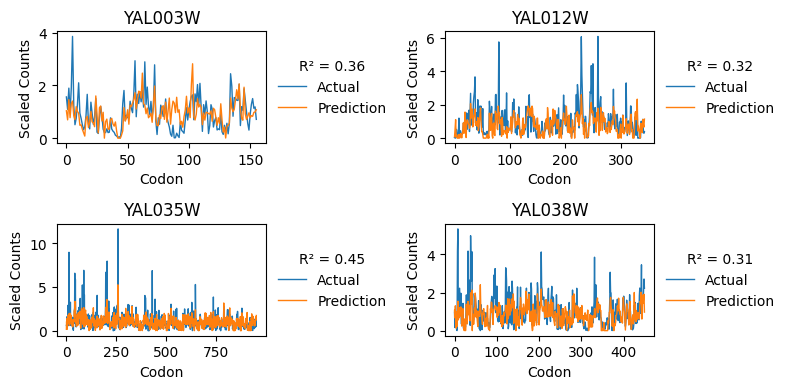

In [20]:
fig, axs, which = initialize_multiplot(4, n_cols=2, figsize=(8, 4))

for gene in ydf["gene"].unique()[:4]:
    row, col = next(which)
    pred, actual = pred_gene(gene, ydf, model_w)
    plot_counts(pred, actual, ax=axs[row, col])
    axs[row, col].set_title(gene)
plt.tight_layout()
plt.show()

# Overall Evaluation

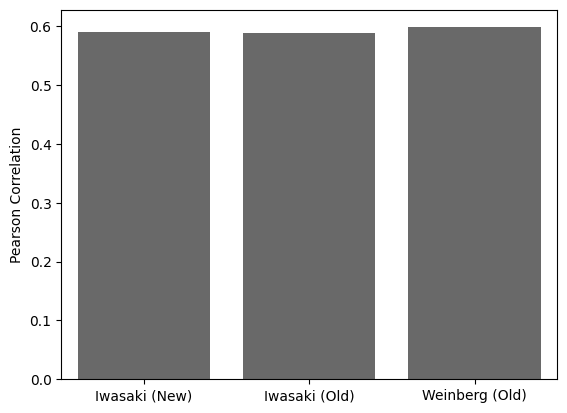

In [21]:
labels = ["Iwasaki (New)", "Iwasaki (Old)", "Weinberg (Old)"]
rvals = [jack.pearson_r.statistic, rob.pearson_r.statistic, weinberg.pearson_r.statistic]

fig, ax = plt.subplots()
sns.barplot(x=labels, y=rvals, color='dimgrey')
# ax.bar(labels, rvals)
ax.set_ylabel("Pearson Correlation")
plt.show()

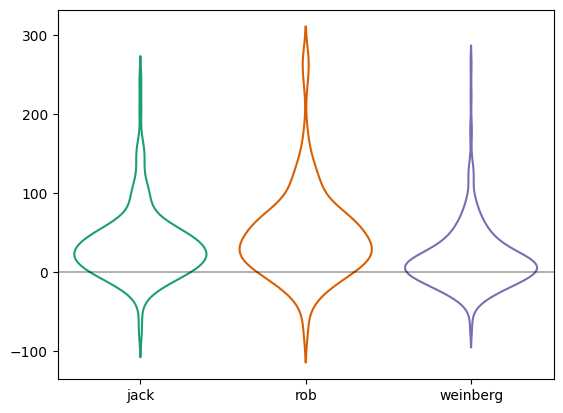

In [22]:
def compare_tots(expt:Experiment):
    scaled_tot_a = expt.ydf.groupby("gene")["scaled_cts"].sum() 
    scaled_tot_p = expt.ydf.groupby("gene")["prediction"].sum()
    return scaled_tot_a - scaled_tot_p

tots = {
    "jack": compare_tots(jack),
    "rob": compare_tots(rob),
    "weinberg": compare_tots(weinberg)
}

plt.axhline(0, c='k', alpha=0.3)
sns.violinplot(tots, fill=None, inner=None, palette="Dark2")
plt.show()

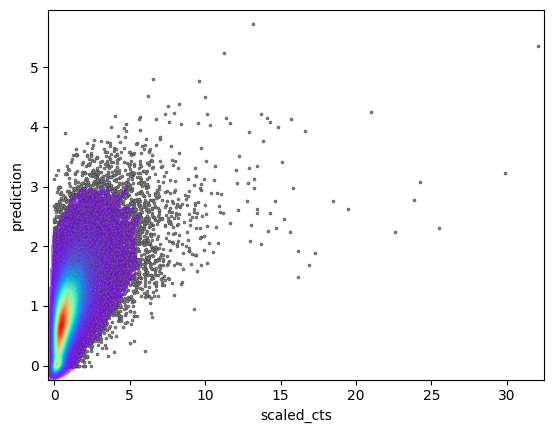

In [23]:
sns.scatterplot(
    weinberg.ydf, x="scaled_cts", y="prediction",
    s=5, edgecolor='k', c='grey', 
    # fill=True, cmap="viridis"
)
sns.kdeplot(
    weinberg.ydf, x="scaled_cts", y="prediction",
    fill=True, cmap="rainbow", levels=100, alpha=0.5, thresh=0.01
)
plt.show()

In [24]:
from Bio.Seq import Seq

myseq = Seq(jack.gdf.iloc[0]["cod_gene"])
myseq = Seq(jack.gdf.iloc[0]["seq"])
print(myseq)
print(myseq.transcribe())
print(myseq.translate().split("*"))


GCGCCGCGCGGAGATGACAGCCGAGGAGATGAAGGCGACCGAGAGCGGGGCGCAGTCGGCGCCGCTGCCCATGGAGGGAGTGGACATCAGCCCCAAACAGGACGAAGGCGTGCTGAAGGTCATCAAGAGAGAGGGCACAGGTACAGAGATGCCCATGATTGGGGACCGAGTCTTTGTCCACTACACTGGCTGGCTATTAGATGGCACAAAGTTTGACTCCAGTCTGGATCGCAAGGACAAATTCTCCTTTGACCTGGGAAAAGGGGAGGTCATCAAGGCTTGGGACATTGCCATAGCCACCATGAAGGTGGGGGAGGTGTGCCACATCACCTGCAAACCAGAATATGCCTACGGTTCAGCAGGCAGTCCTCCAAAGATTCCCCCCAATGCCACGCTTGTATTTGAGGTGGAGTTGTTTGAGTTTAAGGGAGAAGATCTGACGGAAGAGGAAGATGGCGGAATCATTCGCAGAATACAGACTCGCGGTGAAGGCTATGCTAAGCCCAATGAGGGTGCTATCGTGGAGGTTGCACTGGAAGGGTACTACAAGGACAAGCTCTTTGACCAGCGGGAGCTCCGCTTTGAGATTGGCGAGGGGGAGAACCTGGATCTGCCTTATGGTCTGGAGAGGGCCATTCAGCGCATGGAGAAAGGAGAACATTCCATCGTGTACCTCAAGCCCAGCTATGCTTTTGGCAGTGTTGGGAAGGAAAAGTTCCAAATCCCACCAAATGCTGAGCTGAAATATGAATTACACCTCAAGAGTTTTGAAAAGGCCAAGGAGTCTTGGGAGATGAATTCAGAAGAGAAGCTGGAACAGAGCACCATAGTGAAAGAGCGGGGCACTGTGTACTTCAAGGAAGGTAAATACAAGCAAGCTTTACTACAGTATAAGAAGATCGTGTCTTGGCTGGAATATGAGTCTAGTTTTTCCAATGAGGAAGCACAGAAAGCACAGGCCCTTCGACTGGCCTCTCACCTCAACCTGGCCATGTGTCAT

/mnt/lareaulab/demaray/miniconda3/envs/ixnos/lib/python3.12/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
